# EOF Analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import datetime
from dateutil.relativedelta import relativedelta
import time

from cartopy import crs as ccrs, feature as cfeature
import warnings
warnings.filterwarnings('ignore')

import xarray as xr
import glob, os
os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'
import xskillscore as xs

from eofs.xarray import Eof
from eofs.standard import Eof as sEof # If needed
from eofs.multivariate.standard import MultivariateEof

from scipy import stats
import statsmodels.api as sm

sp = ccrs.SouthPolarStereo()
pc = ccrs.PlateCarree()
import matplotlib.patches as mpatches

%run utils.ipynb

# 1. Load in the model datasets

In [2]:
# LOAD SIC: 1x0.5
filename = 'gs://leap-persistent/dhruvbalwada/SI_pred_project/sic_1X0p5.zarr'
sic_anom_ds = xr.open_zarr(filename)
sic_anom = sic_anom_ds.sic_anom_smoothed

# LOAD 6 (for now) other model variables: 2x2
filename = 'gs://leap-persistent/dhruvbalwada/SI_pred_project/vars_2x2.zarr'
vars_2x2 = xr.open_zarr(filename)
sst_anom = vars_2x2.sst_anom_smoothed    # 1
sat_anom = vars_2x2.sat_anom_smoothed    # 2
z_anom = vars_2x2.z_anom_smoothed        # 3
u_anom = vars_2x2.u_anom_smoothed        # 4
v_anom = vars_2x2.v_anom_smoothed        # 5
sthf_anom = vars_2x2.sthf_anom_smoothed  # 6

# File naming conventions, selecting # of vars:
var_names = ['sic', 'sst', 'sat', 'z', 'u', 'v', 'sthf']

#___ CHANGE the scaling here!
var_scaling = [2, 1, 1, 0.5, 0.5, 0.5, 1]
#var_scaling = [2, 1, 1, 1, 1, 1, 1]
#var_scaling = [2, 1, 1, 0.5, 0.5, 0.5, 0.5]

# GOAL: Get new stds's, then normalize anomalies, so now all of the anomaly std's are = 1. on same scale.

# Calculate new std's, save new stds into one array.
sic_std = sic_anom.std() / var_scaling[0]
sst_std = sst_anom.std() / var_scaling[1]
sat_std = sat_anom.std() / var_scaling[2]
z_std = z_anom.std() / var_scaling[3]
u_std = u_anom.std() / var_scaling[4]
v_std = v_anom.std() / var_scaling[5]
sthf_std = sthf_anom.std() / var_scaling[6]
stds = [sic_std, sst_std, sat_std, z_std, u_std, v_std, sthf_std]

# Normalize the anomalies, save normalized anomalies into one array
norm_sic_anom = sic_anom/sic_std
norm_sst_anom = sst_anom/sst_std
norm_sat_anom = sat_anom/sat_std
norm_z_anom = z_anom/z_std
norm_u_anom = u_anom/u_std
norm_v_anom = v_anom/v_std
norm_sthf_anom = sthf_anom/sthf_std

# Convert normalized anomalies to numpy normalizes anomalies.
np_sic_anom = norm_sic_anom.to_numpy()
np_sst_anom = norm_sst_anom.to_numpy()
np_sat_anom = norm_sat_anom.to_numpy()
np_z_anom = norm_z_anom.to_numpy()
np_u_anom = norm_u_anom.to_numpy()
np_v_anom = norm_v_anom.to_numpy()
np_sthf_anom = norm_sthf_anom.to_numpy()
np_vars = [np_sic_anom, np_sst_anom, np_sat_anom, np_z_anom, np_u_anom, np_v_anom, np_sthf_anom]

# Latitude weight creation
sic_wgts = np.cos(np.deg2rad(sic_anom_ds.coords['y'].values)).clip(0., 1.)[..., np.newaxis]
#     sic_wgts = np.cos(np.deg2rad(sic_anom_ds.y.data))[:, np.newaxis] also works.
vars_wgts = np.cos(np.deg2rad(vars_2x2.coords['y'].values)).clip(0., 1.)[..., np.newaxis]

# 2. Choose the # of variables and # of modes, to run the hindcast + cross validation markov model creation.

### define the setup_model function below

### HERE: Change the indices, corresponding to the variables you want to include in the model.

In [3]:
def setup_model(indices):
    model_vars = [np_vars[x] for x in indices]
    f_start = '_'.join([var_names[x] for x in indices])
    f_scal = '*'.join([str(var_scaling[x]) for x in indices])
    f_name = f_start + '-' + f_scal
    model_wgts = [sic_wgts]
    for x in range(len(indices)-1):
        model_wgts.append(vars_wgts)
    return model_vars, model_wgts, f_name

In [4]:
# reminder: var_names = ['sic', 'sst', 'sat', 'z', 'u', 'v', 'sthf']
indices = [0, 1, 2, 3, 4, 5, 6] # our best one we think: 0, 1, 2, 6
#indices = [0, 1, 2]
model_vars, model_wgts, f_name = setup_model(indices)
nv = len(indices)
print(f_name)

sic_sst_sat_z_u_v_sthf-2*1*1*0.5*0.5*0.5*1


### Run the MEOF solver

In [5]:
# We think modes 9-12 are pretty good. Stick w 9 maybe, for final model.
for modes in range(49,50):
    # Give the output a full file name in the format:
    # variables_separated_by_underscores - weights*separated*by*astericks - #ofmodes
    complete_fname = f_name+'-'+ str(modes) + '.nc'
    print('Building hcast and cross for: '+ complete_fname)
    
    # run the solver here.
    solver = MultivariateEof(model_vars,
                         weights = model_wgts, center=False)
    nvars = nv-1 # nvars: number of variables NOT sic. ex. sst, sat: nvars = 2. i=0, 1.
    
    #____________________Solve for MEOFs, PCs
    # define the lat, lon coordinates for the variables.
    sic_lat_bins = np.arange(-89.5, -49.5, 0.5)
    sic_lon_bins = np.arange(0., 360, 1)
    vars_lat_bins = np.arange(-88., -49, 2)
    vars_lon_bins = np.arange(0., 359, 2)

    # get the eofs, pcs, eigenvalues here.
    np_eofs_list = solver.eofs(neofs=modes) # scale by something here?
    np_eofscov_list = solver.eofsAsCovariance(neofs=modes)
    np_pcs = solver.pcs(npcs=modes)
    np_eigs = solver.eigenvalues(neigs=modes) 
    sum_eigs = solver.eigenvalues().sum()
    percent_var = np_eigs.sum() / solver.eigenvalues().sum()
    tav = solver.totalAnomalyVariance()
    vf = solver.varianceFraction()

    # turn the list of eofs for each variable used in the model into SIC_EOFs, and the rest of the eofs.
    sic_eofs = xr.DataArray(np_eofs_list[0],
                           coords = [np.arange(0, modes), sic_lat_bins, sic_lon_bins],
                            dims=['mode', 'y', 'x']) * stds[0]
    all_vars_eofs = [sic_eofs] # all_vars_eofs is eventually what has all the eofs to be plotted.
    for i in range(nvars):
        all_vars_eofs.append(xr.DataArray(np_eofs_list[i + 1],
                           coords = [np.arange(0, modes), vars_lat_bins, vars_lon_bins],
                            dims=['mode', 'y', 'x']) * stds[i + 1])
        
    # for each mode, get the pc timeseries for all the eofs.
    pcs = xr.DataArray(np_pcs, coords=[sic_anom.tdim, np.arange(0, modes)],
                      dims=['tdim', 'mode'])
    
    # Collapse sic_eofs and other eofs from 2d into 1d.
    stacked_sic_eofs = sic_eofs.stack(n=("y","x"))#28800 grid points
    all_stacked_eofs = [stacked_sic_eofs] # all_stacked_eofs is eventually all the stacked eofs.
    for i in range(nvars):
        all_stacked_eofs.append(all_vars_eofs[i+1].stack(n=("y", "x"))) #append a multiple of 3600 grid points
    meofs_2d = xr.concat(all_stacked_eofs, "n") 
  

Building hcast and cross for: sic_sst_sat_z_u_v_sthf-2*1*1*0.5*0.5*0.5*1-49.nc


### Data conversion into Pandas Dataframe for easier manipulation

In [7]:
num_modes = 9

# Get a list of the modes you want to select
selected_modes = list(range(num_modes))

# Create an empty DataFrame
df = pd.DataFrame()

# Loop over each selected mode
for mode in selected_modes:
    # Select data for the current mode
    ds_mode = pcs.isel(mode=mode)

    # Convert the selected data to a DataFrame, reset the index and drop the 'mode' column
    df_mode = ds_mode.to_dataframe(name=f'pc{mode}').reset_index().drop(columns='mode')

    # Add a new column 'original_order' that represents the original order of the rows
    df_mode['original_order'] = np.arange(len(df_mode))

    # If df is empty, assign df_mode to df. Otherwise, merge df_mode into df.
    if df.empty:
        df = df_mode
    else:
        df = pd.merge(df, df_mode, on=['tdim', 'original_order'])

# Drop the 'original_order' column and reset index
df = df.drop(columns='original_order')
df = df.drop(columns='tdim')


df


,pc0,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8
0,-7.994032,36.308796,-0.824233,1.139894,-27.681397,39.774889,-2.390738,31.218495,-12.143205
1,-7.752467,33.796405,-1.734881,1.780575,-22.968520,31.702601,6.721040,35.371396,-10.426323
2,-0.872938,32.699738,-1.165220,3.792807,-28.986954,29.588035,1.631369,30.530838,-17.492498
3,-3.764602,31.010540,8.677655,3.465575,-40.652401,26.302734,-11.189121,32.970133,-26.299725
4,-7.169449,19.542715,4.931846,-0.102418,-52.486422,23.339192,-31.685118,34.377969,-26.275393
...,...,...,...,...,...,...,...,...,...
511,51.748023,-34.544995,-4.951340,38.404709,3.608128,36.067576,3.347722,-2.905891,-1.749934
512,63.758528,-23.154314,-2.602468,44.432835,29.380615,28.539046,13.896787,-11.000237,-20.736761
513,83.076769,-19.436222,-13.110027,37.419936,47.671281,3.572306,25.598061,-27.582077,-17.993779
514,81.823697,-3.817977,-23.283152,14.598134,69.636998,-23.407908,27.877454,-25.758277,0.242983


### Sliding Window Algorithm for Data Splitting

In [8]:
def df_to_X_y(df, windowsize):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np) - windowsize):
        # Create the input sequence with the corresponding pc values
        input_sequence = df_as_np[i:i+windowsize, 0:num_modes+1]  # 'pc' values from rows i to i+windowsize and columns 1, 2, and 3

        # Add the corresponding output value
        output_value = df_as_np[i+windowsize, 0:num_modes+1]  # 'pc' value at the next time step from column 1, 2, and 3

        X.append(input_sequence.flatten())  # flattened to ensure correct shape
        y.append(output_value)

    return np.array(X), np.array(y)


In [9]:
window_val = 3
X,y = df_to_X_y(df, window_val)
#X = X.reshape(X.shape[0], -1)
input_size = X.shape[1]

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Model 

In [11]:
from scipy.stats import pearsonr
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dropout
from keras.layers import Dense
from utils import * 
from sklearn.metrics import mean_squared_error

2023-07-30 21:11:47.930322: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-30 21:11:48.014411: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [12]:
np.random.seed(42)
tf.random.set_seed(42)

In [13]:
# set hyperparameters
n_neuron       = 64
num_epochs     = 150
learning_rate  = 0.001
minibatch_size = 32

In [14]:
model = Sequential()

dropout_rate = 0.2

model.add(Dense(n_neuron,  activation='linear', name="hidden_layer_1" ,input_shape=(input_size,)))

model.add(Dense(n_neuron,  activation='linear', name="hidden_layer_2"))

#model.add(Dense(n_neuron,  activation='relu', name="hidden_layer_3"))

#model.add(Dense(n_neuron,  activation='relu', name="hidden_layer_4"))

model.add(Dense(num_modes, activation='linear', name="output_layer"))

model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

2023-07-30 21:11:49.700810: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/nvidia/lib64
2023-07-30 21:11:49.700839: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)


In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer_1 (Dense)      (None, 64)                1792      
                                                                 
 hidden_layer_2 (Dense)      (None, 64)                4160      
                                                                 
 output_layer (Dense)        (None, 9)                 585       
                                                                 
Total params: 6,537
Trainable params: 6,537
Non-trainable params: 0
_________________________________________________________________


In [16]:
history = model.fit(X_train, y_train, 
                    batch_size      = minibatch_size,
                    epochs          = num_epochs,
                    validation_split= 0.2, 
                    verbose         = 1,
                    callbacks       = None )

Epoch 1/150
11/11 [==============================] - 1s 14ms/step - loss: 1394.1315 - val_loss: 971.5146
Epoch 2/150
11/11 [==============================] - 0s 3ms/step - loss: 576.8237 - val_loss: 621.3740
Epoch 3/150
11/11 [==============================] - 0s 3ms/step - loss: 422.3799 - val_loss: 469.3929
Epoch 4/150
11/11 [==============================] - 0s 3ms/step - loss: 322.5585 - val_loss: 391.5834
Epoch 5/150
11/11 [==============================] - 0s 3ms/step - loss: 278.4644 - val_loss: 347.4023
Epoch 6/150
11/11 [==============================] - 0s 3ms/step - loss: 247.3403 - val_loss: 313.1566
Epoch 7/150
11/11 [==============================] - 0s 3ms/step - loss: 222.9014 - val_loss: 290.3731
Epoch 8/150
11/11 [==============================] - 0s 3ms/step - loss: 204.1705 - val_loss: 270.6490
Epoch 9/150
11/11 [==============================] - 0s 3ms/step - loss: 190.7618 - val_loss: 252.2326
Epoch 10/150
11/11 [==============================] - 0s 3ms/step - los

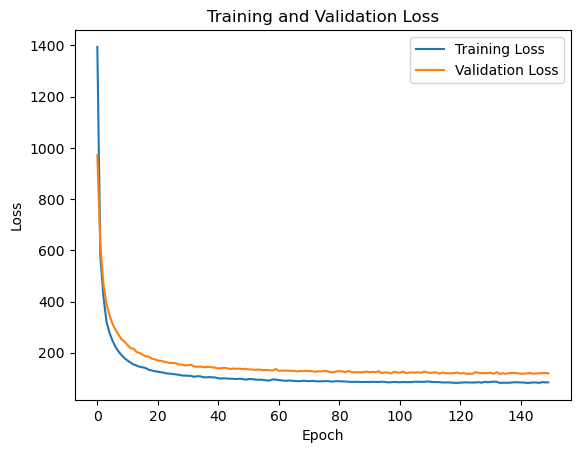

In [17]:
# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Save the Model and Test 1 Month Predictions

In [18]:
cwd = os.getcwd()
model_path = os.path.join(cwd,'saved_model')
make_dir(model_path)
model.save(os.path.join(model_path,'model.h5'))
model = load_model(os.path.join(model_path,'model.h5'))

In [19]:
y_test_pred = model.predict(X_test)

4/4 [==============================] - 0s 1ms/step


In [20]:
y_all_pred = model.predict(X)

17/17 [==============================] - 0s 779us/step


### n_months lead time for all points in X_test

In [21]:
def get_n_month_forecasts(X_test, model, num_pcs, num_months):
    forecasts = []

    # Loop over all data points in the test set
    for i in range(len(X_test)):

        # Select the i-th data point
        input_data = X_test[i].copy()
        forecast = []

        # Loop to generate num_months forecasts
        for _ in range(num_months):

            # Make a prediction using the current input data
            prediction = model.predict(input_data[np.newaxis, ...], verbose=0)[0]

            # Append the prediction to the forecast
            forecast.append(prediction)

            # shift all values
            input_data[:-num_pcs] = input_data[num_pcs:]

            # update the last 'num_pcs' values with the prediction
            input_data[-num_pcs:] = prediction

        # Append the forecast for current data point to the list of all forecasts
        forecasts.append(forecast)

    return np.array(forecasts)


num_pcs = num_modes
n_months = 1
n_month_forecasts = get_n_month_forecasts(X, model, num_pcs, n_months)

# Data Reconstruction

In [22]:
pc = ccrs.PlateCarree()
lead_time_forecasts = n_month_forecasts[:, n_months-1, :]

In [23]:
dateofinterest = '2014-07-01'
time_values = (pcs.isel(mode=0)[window_val:])['tdim'].values
predicted_pcs = []

for i in range(num_modes):
    predicted_pcs.append(lead_time_forecasts[:, i])

In [24]:
from datetime import datetime
from dateutil.relativedelta import relativedelta

# Define the start and end dates as strings
start_date_str = '2013-05-01'
end_date_str = '2020-12-01'

# Convert the start and end dates to datetime objects
start_date = datetime.strptime(start_date_str, '%Y-%m-%d')
end_date = datetime.strptime(end_date_str, '%Y-%m-%d')

# Initialize an empty list to store the dates of interest
datesofinterest = []

# Iterate through the dates from start_date to end_date, adding one month at a time
current_date = start_date
while current_date <= end_date:
    # Convert the current date to a string and add it to the list
    datesofinterest.append(current_date.strftime('%Y-%m-%d'))
    
    # Move to the next month using relativedelta to handle month overflow
    current_date += relativedelta(months=1)

In [25]:
real_set = sic_anom.isel(tdim=slice(412, 504))

In [32]:
correlations = []
mse_list = []
r_squared_list = []

for dateofinterest in datesofinterest:
    intermediate_reconstructions = []
    # Loop over each predicted PC and its corresponding EOF index
    for predpc, eof_index in zip(predicted_pcs, range(len(sic_eofs))):
        # Create a new_xarray for the current predicted PC
        new_xarray = xr.DataArray(predpc, coords=[time_values], dims=['tdim'])

         # Perform the reconstruction for the current predicted PC using the corresponding EOF
        intermediate_reconstruction = sic_eofs[eof_index] * new_xarray.sel(tdim=dateofinterest)

        # Append the intermediate_reconstruction to the list
        intermediate_reconstructions.append(intermediate_reconstruction)
    
    # Sum all the intermediate reconstructions together
    summed_modes = sum(intermediate_reconstructions)
    
    # Divide by lat(cosine)
    final_reconstruction = np.divide(summed_modes, sic_wgts)
    
    correlation = np.corrcoef(final_reconstruction.values.flatten(), real_set.sel(tdim=dateofinterest).values.flatten())[0, 1]
    mse = mean_squared_error(real_set.sel(tdim=dateofinterest), final_reconstruction)
    r_squared = correlation ** 2
    
    mse_list.append(mse)
    correlations.append(correlation)
    r_squared_list.append(r_squared)

In [36]:
def find_average(float_list):
    total_sum = sum(float_list)
    num_elements = len(float_list)
    average = total_sum / num_elements
    return average

result_corr = find_average(correlations)
result_rmse = np.sqrt(find_average(mse_list))
result_rsqrt = find_average(r_squared_list)
print(result_corr)
print(result_rmse)
print(result_rsqrt)

0.5814310672053217
0.04984070262915035
0.3541617187752281


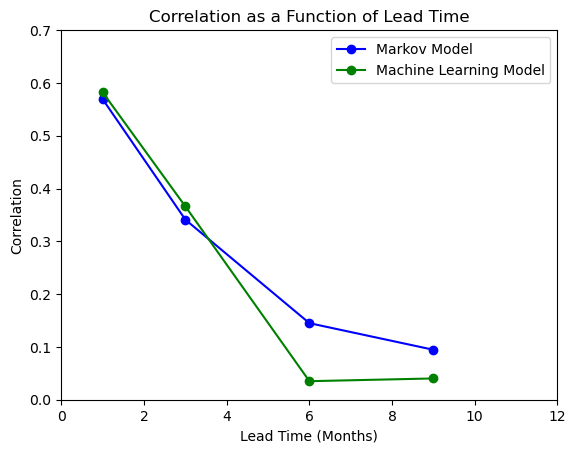

In [42]:
# Data: Four ordered pairs
markov_cors = [0.569, 0.341, 0.145, 0.0946]
daddy_dave_cors = [0.582, 0.366, 0.0351, 0.0403]
markov_r2 = [0.324, 0.116, 0.021, 0.0090]
dave_r2 = [0.339, 0.134, 0.0012, 0.0016]
lead_times = [1, 3, 6, 9]

# Set the x-axis and y-axis ranges
plt.xlim(0, 12)
plt.ylim(0, 0.7)

# Plot the ordered pairs as dots for the first dataset
plt.plot(lead_times, markov_cors, marker='o', linestyle='-', color='b', label='Markov Model')

# Plot the ordered pairs as dots for the second dataset
plt.plot(lead_times, daddy_dave_cors, marker='o', linestyle='-', color='g', label='Machine Learning Model')

# Add labels and title to the plot
plt.xlabel('Lead Time (Months)')
plt.ylabel('Correlation')
plt.title('Correlation as a Function of Lead Time')

# Add a legend to identify the datasets
plt.legend()

# Display the plot
plt.show()

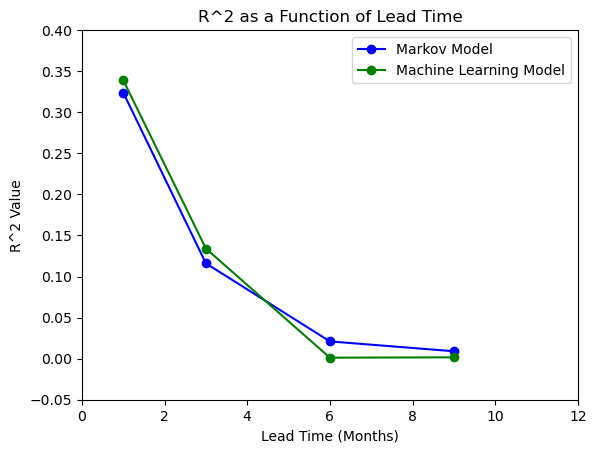

In [47]:
# Set the x-axis and y-axis ranges
plt.xlim(0, 12)
plt.ylim(-0.05, 0.4)

# Plot the ordered pairs as dots for the first dataset
plt.plot(lead_times, markov_r2, marker='o', linestyle='-', color='b', label='Markov Model')

# Plot the ordered pairs as dots for the second dataset
plt.plot(lead_times, dave_r2, marker='o', linestyle='-', color='g', label='Machine Learning Model')

# Add labels and title to the plot
plt.xlabel('Lead Time (Months)')
plt.ylabel('R^2 Value')
plt.title('R^2 as a Function of Lead Time')

# Add a legend to identify the datasets
plt.legend()

# Display the plot
plt.show()